# Prepare calibration dataframe summary

This notebook serves the single purpose of building the energy sums and global compensation factors in regions of the HGCAL detector. The result is a dataframe with the final variables needed to run in a calibration loop.

To use spark do not forget to start the configuration with K8s and to connect to spark prior to any operation.

Author: P. Silva (psilva@cern.ch)
Date: 23/03/2022

In [4]:
%load_ext autoreload
%autoreload 2
import os
import datetime
import ROOT
import PyRDF
import pandas as pd
import numpy as np
from utils.energy_regression_tools import *
from utils.semiparametric_model import *
from utils.calib_tools import *
from utils.rounding import *
import mplhep as hep
plt.style.use([hep.style.CMS, hep.style.firamath])

#_indir='/eos/cms/store/cmst3/user/psilva/HGCAL/K0L_studies/2022Mar25'
_indir='/eos/user/p/psilva/data/hgcal/k0l'
_outdir=_indir+'/summaries'
os.system('mkdir -p {}'.format(_outdir))
_plotdir='/eos/user/p/psilva/www/HGCAL/geom/K0L_studies/{}'.format(datetime.datetime.now().strftime('%Y%b%d'))
os.system('mkdir -p {}'.format(_plotdir))                             

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


0

# 1. Convert the ROOT tuples to pandas

This only needs to be done once to get an easier to handle format

In [ ]:
def prepareCalibrationDataFrame(files,root='ana',local=False):

    """
    wraps the procedure of selecting the events and collecting the necessary info in a small dataframe
    returns a pandas DataFrame.
    files - a list of files
    genId - the particle id to analyze
    sum_defs - the sum definitions (see previous cell for the definition of the dict)
    local - if True spark is not used
    """
    
    if local:
        ROOT.ROOT.EnableImplicitMT()
        PyRDF.use('local')
    else:
        PyRDF.use('spark', {'npartitions':12})
        files = ['root://eosuser.cern.ch/{}'.format(x) if x.find('root:')<0 else x for x in files]
            
    #define the selections and branches with an RDataFrame
    rdf = PyRDF.RDataFrame(f"{root}/hits", files)
    start_count=rdf.Count()
    rdf = rdf.Filter('crosscalo>0')
    filter_count=rdf.Count()
    
    print('Total at start:',start_count.GetValue())
    print('Total pre-selected:',filter_count.GetValue())
    
    #filter only the columns of interest
    df = pd.DataFrame(rdf.AsNumpy())
    df = df.astype({'crosscalo':'bool'}) #booleans are propagated as objects in pandas
    
    col_map =  [ ('e_cee120','sumen_CEESi100'),('e_cee200','sumen_CEESi200'),('e_cee300','sumen_CEESi300') ]
    col_map += [ ('e_cehfine120','sumen_CEHfineSi100'),('e_cehfine200','sumen_CEHfineSi200'),('e_cehfine300','sumen_CEHfineSi300') ]
    col_map += [ ('e_cehcoarse120','sumen_CEHcoarseSi100'),('e_cehcoarse200','sumen_CEHcoarseSi200'),('e_cehcoarse300','sumen_CEHcoarseSi300') ]
    col_map += [ ('e_cehscifine','sumen_CEHScifine'),('e_cehscicoarse','sumen_CEHScicoarse') ]
    col_map += [ ('genergy','genEn'), ('gpt','genEt'), ('geta','genEta'),('gphi','genPhi'),('c_glob','c_glob')]
    col_map = dict(col_map)
    df.rename(inplace=True,columns=col_map)
    df.drop(columns=['e_raw','gvradius','gvz'],inplace=True)
    return df

#prepareCalibrationDataFrame(f'{indir}/test.root',local=True).head()

In [ ]:
#convert root files to HDF
local=True

flist=[os.path.join(_indir,f) for f in os.listdir(_indir) if '.root' in f and not 'test' in f]
print(f'{len(flist)} files found')

for tag in ['','_antikt','_no3','_lc_antikt','_lc_antikt_no3','_lc_ca']:
    
    root=f'ana{tag}'
    print(f'Analyzing hits from {root}')

    df=prepareCalibrationDataFrame(flist,root=root,local=local)

    #filter pseudo-rapidity
    df['genAbsEta'] = np.abs(df['genEta'])
    df=df[ (df['genAbsEta']>=1.7) & (df['genAbsEta']<=2.3)  ]

    #categorize
    df['eta_cat'] = np.digitize(df['genAbsEta'], bins=[1.7,1.75,1.8,1.9,2.0,2.1,2.2,2.3])
    df['et_cat'] = np.digitize(df['genEn'], bins=[10,15,20,25,30,40,50,60,70,80,100,120,150,200,250,300,350,400,450,500])
    
    out_f=os.path.join(_outdir,'energysums{}.h5'.format(tag))
    df.to_hdf(out_f, key='data', mode='w')
    
    print('{} created with shape={}'.format(out_f,df.shape))
    
    #use the last dataframe to count the number of available showers
    #grouped_df=df.set_index( ['et_cat','eta_cat'] )
    #level=[0,1]
    #scan_summary = { 'genEt'     : grouped_df.mean(level=level)['genEt'],
    #             'genEn'     : grouped_df.mean(level=level)['genEn'],
    #             'genAbsEta' : grouped_df.mean(level=level)['genAbsEta'],}
    #scan_summary['nshowers'] = (grouped_df.sum(level=level)['genEt']/scan_summary['genEt']).astype(int)
    #scan_summary = pd.DataFrame(scan_summary)
    #scan_summary.sort_index(inplace=True)
    #scan_summary.reset_index(inplace=True)
    #print('Showers available')
    #print(scan_summary['nshowers'].describe())
    #scan_summary.head(-1)

    del df

# 2. Run the calibration procedure

Start by running the calibration on the full acceptance reconstructed showers.

In [5]:
def prepareForCalib(df,maxfcee):
    
    x_features=[x for x in df.columns if 'sumen_' in x]
    df['en_l0']=df[x_features].sum(axis=1)
    df['fcee']=df[['sumen_CEESi100','sumen_CEESi200','sumen_CEESi300',]].sum(axis=1)/df['en_l0']
    
    if not maxfcee is None: 
        mask=(df['fcee']<maxfcee)
        df=df[mask]
        print(f'Applying mask for maxfcee<{maxfcee} will select {mask.sum()} out of {df.shape[0]} showers')
    
    return df,x_features

In [ ]:
#run different calibrations
for tag, url, maxfcee in [ 
        ('',           'energysums',           None),
        ('_late',      'energysums',           0.1),
        ('_antikt',    'energysums_antikt',    None),
        ('_lc_antikt', 'energysums_lc_antikt', None),
        ('_lc_ca',     'energysums_lc_ca',     None),
    ]:
    
    print(f'Running calibration from {url} with tag={tag} and maxfcee={maxfcee}')
    
    #read the summary, define baseline energy estimator and apply bias if required
    url=f'{_indir}/summaries/{url}.h5'
    df=pd.read_hdf(url,key='data')
    df,x_features=prepareForCalib(df,maxfcee)

    #run the regression for the relative weights of the different sections
    print('Features',x_features)
    coeffs=doL1Regression(df,x_features,outdir=None) #_plotdir)
    coeffs_url=url=f'{_indir}/summaries/l1coeffs{tag}.h5'
    coeffs.to_hdf(coeffs_url,key='l1coeffs')
    print('Calibration coefficients have been stored in',coeffs_url)
    
    #regularize the coefficients with a functional form
    reg_coeffs=regularizeCalibCoeffs(coeffs,outdir=_plotdir,plot_tag=tag)
    regcoeffs_url=coeffs_url.replace('l1coeffs','l1regcoeffs')
    reg_coeffs.to_hdf(regcoeffs_url,key='l1coeffs')
    print('Regularized calibration coefficients have been stored in',regcoeffs_url)
    
    del df

In [ ]:
%%time

#this step may take a while to complete (~7 min per tag)
for tag, calibtag, url, maxfcee in [ 
                           ('',               '',               'energysums',               None),
                           ('_late',          '_late',          'energysums',               0.1),
                           ('_no3',           '',               'energysums_no3',           None),
                           ('_no3_late',      '_late',          'energysums_no3',           0.1), 
                           ('_antikt',        '_antikt',        'energysums_antikt',        None),
                           ('_lc_antikt',     '_lc_antikt',     'energysums_lc_antikt',     None),
                           ('_lc_antikt_no3', '_lc_antikt',     'energysums_lc_antikt_no3', None),
                           ('_lc_ca',         '_lc_ca',         'energysums_lc_ca',         None),
                         ]:

    print(f'Applying L1 calibration from l1regcoeffs{calibtag} to {url} and storing with tag=_calib{tag} (maxfcee={maxfcee})')
    
    #read the summary
    url=f'{_indir}/summaries/{url}.h5'
    df=pd.read_hdf(url,key='data')
    df,_=prepareForCalib(df,maxfcee)
    
    #read the coefficients
    regcoeffs_url=f'{_indir}/summaries/l1regcoeffs{calibtag}.h5'
    reg_coeffs=pd.read_hdf(regcoeffs_url,key='l1coeffs')
    
    df=applyL1Correction(df,reg_coeffs)

    #compute the final residuals
    df=doResiduals(df,outdir=_plotdir,plot_tag=tag)

    #final dataframe
    calib_url=url.replace('.h5',f'_calib{tag}.h5')
    df.to_hdf(calib_url,key='data',mode='w')
    print('Calibrated data @',calib_url)
    
    del df

# 2a. Run a semi-parametric calibration

For the training of a semi-parametric regression please use the dedicated notebook

# 3. Control plots

If starting from here please evaluate the first cell (imports) and the cell defining the `prepareForCalib` method

1. comparison of resolutions
2. check pre/post-calibration response
3. check pre/post-calibration sub-detector balancing

In [22]:
#resolution
kwargs={'samples':[('default',  f'{_indir}/summaries/energysums_calib.h5'),
                   ('no 3',     f'{_indir}/summaries/energysums_no3_calib_no3.h5'),
                  ],
        'bounds':[(0.15,0.,0.),(1.5,1e-3,0.20)],
        'doRatio':True,
        'doGaussianCore':True,
        'minGenEn':0,
        'outname':os.path.join(_plotdir,'L1resol_simple'),
        'levels':['l1_res'],
        'ratioran':(0.9,1.2)}
showResolutionFit(**kwargs)

kwargs['samples']=[('default',  f'{_indir}/summaries/energysums_calib_late.h5'),
                   ('no 3',     f'{_indir}/summaries/energysums_no3_calib_no3_late.h5'),
                  ]
kwargs['outname']=os.path.join(_plotdir,'L1resolLateShowers_simple')
kwargs['minGenEn']=50
showResolutionFit(**kwargs)

In [23]:
#resolution (After regresssion)
kwargs={'samples':[('default',  f'{_indir}/summaries/energysums_calib_regressed.h5'),
                  ],
        'bounds':[(0.15,0.,0.),(1.5,1e-3,0.20)],
        'levels':['l1_res','l1reg_res'],
        'levelsTitle':['simple parametric','semi-parametric'],
        'doRatio':False,
        'doGaussianCore':True,
        'minGenEn':0,
        'outname':os.path.join(_plotdir,'L1resolcompared'),
        'ratioran':(0.9,1.2)}
showResolutionFit(**kwargs)


kwargs['samples']=[('default',  f'{_indir}/summaries/energysums_calib_late_regressed.h5'),]
kwargs['outname']=os.path.join(_plotdir,'L1resolcomparedLateShowers')
kwargs['minGenEn']=50
showResolutionFit(**kwargs)

In [21]:
#resolution (After regresssion)
kwargs={'samples':[('default',  f'{_indir}/summaries/energysums_calib_regressed.h5'),
                   ('no 3',     f'{_indir}/summaries/energysums_no3_calib_no3_regressed.h5'),
                  ],
        'bounds':[(0.15,0.,0.),(1.5,1e-3,0.20)],
        'levels':['l1reg_res'],
        'doRatio':True,
        'doGaussianCore':True,
        'minGenEn':0,
        'outname':os.path.join(_plotdir,'L1resolreg'),
        'ratioran':(0.9,1.2)}
showResolutionFit(**kwargs)

kwargs['samples']=[('default',  f'{_indir}/summaries/energysums_calib_late_regressed.h5'),
                   ('no 3',     f'{_indir}/summaries/energysums_no3_calib_no3_late_regressed.h5'),
                  ]
kwargs['outname']=os.path.join(_plotdir,'L1resolLateShowers')
kwargs['minGenEn']=50
showResolutionFit(**kwargs)

In [16]:
#resolution clustering algo
kwargs={'samples':[(r'SimHit, $\Delta$ R',       f'{_indir}/summaries/energysums_calib.h5'),
                   (r'SimHit, anti-$k_T$',       f'{_indir}/summaries/energysums_antikt_calib_antikt.h5'),
                   (r'LayerCluster, anti-$k_T$', f'{_indir}/summaries/energysums_lc_antikt_calib_lc_antikt.h5'),
                  ],
        'bounds':[(0.15,0.,0.),(1.5,1e-3,0.20)],
        'doRatio':True,
        'doGaussianCore':True,
        'minGenEn':0,
        'outname':os.path.join(_plotdir,'L1resolclust'),
        'levels':['l1_res'],
        'ratioran':(0.9,1.2)}
showResolutionFit(**kwargs)

kwargs['samples']=[(r'LayerCluster, anti-$k_T$', f'{_indir}/summaries/energysums_lc_antikt_calib_lc_antikt.h5'),
                   (r'LayerCluster, C-A',        f'{_indir}/summaries/energysums_lc_ca_calib_lc_ca.h5')]
kwargs['outname']=os.path.join(_plotdir,'L1resolclustalgo')
showResolutionFit(**kwargs)

In [17]:
#resolution
kwargs={'samples':[('default',  f'{_indir}/summaries/energysums_lc_antikt_calib_lc_antikt.h5'),
                   ('no 3',     f'{_indir}/summaries/energysums_lc_antikt_no3_calib_lc_antikt_no3.h5'),
                  ],
        'bounds':[(0.15,0.,0.),(1.5,1e-3,0.20)],
        'doRatio':True,
        'doGaussianCore':True,
        'minGenEn':0,
        'outname':os.path.join(_plotdir,'L1resolLC'),
        'levels':['l1_res'],
        'ratioran':(0.9,1.2)}
showResolutionFit(**kwargs)

In [18]:
#response distributions
url=f'{_indir}/summaries/energysums_calib_regressed.h5'
df=pd.read_hdf(url,key='data')
for group, data in df.groupby(['eta_cat','et_cat']):
    compareResponse(data,
                    estimators=['en_l0','en_l1_res','en_l1reg_res'], 
                    estimator_titles=['Raw','Corrected','Regressed'],
                    outname=f'{_plotdir}/rawvsl1final_{group[0]}_{group[1]}')

In [25]:
#response distributions (late-start)
url=f'{_indir}/summaries/energysums_calib_late_regressed.h5'
df=pd.read_hdf(url,key='data')
for group, data in df.groupby(['eta_cat','et_cat']):
    if group[1]<4 : continue
    compareResponse(data,
                    estimators=['en_l0','en_l1_res','en_l1reg_res'], 
                    estimator_titles=['Raw','Corrected','Regressed'],
                    outname=f'{_plotdir}/rawvsl1finalLateStart_{group[0]}_{group[1]}')

In [19]:
#profile contributions to energy and balancing of different detector sections

#needs to re-run calibration to add result to the dataframe
#maybe this could go to the regularized calibration step instead so that it's saved in the calibrated summary...
url=f'{_indir}/summaries/energysums_calib.h5'
df=pd.read_hdf(url,key='data')
df,x_features=prepareForCalib(df,None)
doL1Regression(df,x_features,outdir=None)

#enery profiles
profileRelativeContributionsToEnergy(df,sum_name='optim_sumen',doScivsSi=True,outname=f'{_plotdir}/relcontribs_sisipm_optim')
profileRelativeContributionsToEnergy(df,sum_name='optim_sumen',doScivsSi=False,outname=f'{_plotdir}/relcontribs_optim')

#balance between sections
for sum_name in ['sumen','optim_sumen']:
    print(sum_name)
    profileRelativeEnergyBalance(df,sum_name=sum_name,outname=f'{_plotdir}/ebalance_{sum_name}')

[doL1] running regularized L1 calibration
sumen
optim_sumen


In [53]:
#display cglob (global compensation factor)
url=f'{_indir}/summaries/energysums_lc_antikt_calib_lc_antikt.h5'

df=pd.read_hdf(url,key='data')
df,x_features=prepareForCalib(df,None)

for group, data in df.groupby(['eta_cat','et_cat']):
    
    cat_label=r'$E_{{T}}$={:3.0f} GeV $|\eta|$={:3.2f}'.format(data['genEt'].mean(),
                                                               data['genAbsEta'].mean())
          
    cglob=data['c_glob']
    r=data['en_l0']/data['genEn']

    fig,ax=plt.subplots(1,3,figsize=(26,8))
    cglob_bins=np.digitize(cglob,[np.percentile(cglob,q=q) for q in [0,16,50,84,100]])
    cglob_bin_mean = [ fr'$<C_{{glob}}>$={cglob[cglob_bins==b].mean():3.2f}' for b in np.unique(cglob_bins) ][:-1]
    hists=[ r[cglob_bins==b].values for b in np.unique(cglob_bins) ]
    
    ax[0].hist(hists, bins=np.linspace(0.25,1.5,50), density=False, histtype='bar', stacked=True,label=cglob_bin_mean)
    ax[0].grid()
    ax[0].set_xlabel(r'$E_{raw}~/~E_{gen}$')
    ax[0].set_ylabel('Events')
    ax[0].legend(title=cat_label)
    hep.cms.label(loc=0,data=False,ax=ax[0],rlabel='') 

    h=ax[1].hist2d(r,cglob, bins=(np.linspace(0.25,1.5,25),np.linspace(0.25,1.5,25)), 
                   cmap='jet', density=True, norm=ColorsLogNorm(),cmin=1)
    ax[1].grid()
    ax[1].set_xlabel(r'$E_{raw}~/~E_{gen}$')
    ax[1].set_ylabel(r'$C_{glob}$')
    fig.colorbar(h[3], ax=ax[1])
    
    h2=ax[2].hist2d(data['fcee'],cglob, bins=(np.linspace(0.,1.,25),np.linspace(0.25,1.5,25)), 
                   cmap='jet', density=True, norm=ColorsLogNorm(),cmin=1)
    ax[2].set_xlabel(r'$f_{CE-E}$')
    ax[2].set_ylabel(r'$C_{glob}$')
    ax[2].grid()
    fig.colorbar(h2[3], ax=ax[2])
    
    plt.savefig(f'{_plotdir}/cglob_et{group[0]}_eta{group[1]}.png')
    plt.close()

In [20]:
#relative contributions for late showers only
url=f'{_indir}/summaries/energysums_calib.h5'
df=pd.read_hdf(url,key='data')
df,x_features=prepareForCalib(df,0.1)
doL1Regression(df,x_features,outdir=None)

#enery profiles
profileRelativeContributionsToEnergy(df,sum_name='optim_sumen',doScivsSi=True,outname=f'{_plotdir}/relcontribs_sisipm_optim_late')
profileRelativeContributionsToEnergy(df,sum_name='optim_sumen',doScivsSi=False,outname=f'{_plotdir}/relcontribs_optim_late')

Applying mask for maxfcee<0.1 will select 740454 out of 740454 showers
[doL1] running regularized L1 calibration


# 4. Compare energy losses for the same events

In [9]:
%%time

def getMergedDataSet( url1, url2, suffix2,maxfcee=None):
    
    idx=['event','genEta','genPhi','genEn','genEt']
    cols=['eta_cat','et_cat','genAbsEta','en_l0']

    print(f'Merging {url1} with {url2} and maxfcee={maxfcee}')
    
    #open the raw sums for the two cases and merge for the same events
    df = pd.read_hdf(f'{_outdir}/{url1}.h5',key='data')
    df,x_features=prepareForCalib(df,maxfcee)
    df=df[idx+cols]
    df.set_index(idx, inplace=True)
    print('Dataset #1',df.shape)

    df2= pd.read_hdf(f'{_outdir}/{url2}.h5',key='data')
    df2,_=prepareForCalib(df2,maxfcee)
    df2=df2[idx+cols]
    df2.set_index(idx, inplace=True)
    print('Dataset #2',df2.shape)

    df_merged=df.join(df2, how = 'inner', lsuffix='', rsuffix=suffix2)
    df_merged=df_merged[cols + [f'en_l0{suffix2}']]
    print(f'Before (after) merging the number of showers is {df.shape[0]} {(df_merged.shape[0])}')
    
    del df,df2
    return df_merged

#typically 1 min per merge
df_merged={}
df_merged['']=getMergedDataSet('energysums','energysums_no3','no3')
#df_merged['late']=getMergedDataSet('energysums','energysums_no3','no3',0.1)
#df_merged['antikt']=getMergedDataSet('energysums','energysums_antikt','antikt')
#df_merged['lc_antikt']=getMergedDataSet('energysums_antikt','energysums_lc_antikt','lc')
#df_merged['lc_antikt_ca']=getMergedDataSet('energysums_lc_antikt','energysums_lc_ca','ca')


Merging energysums with energysums_no3 and maxfcee=None
Dataset #1 (3372255, 4)
Dataset #2 (3372255, 4)
Before (after) merging the number of showers is 3372255 3372255
CPU times: user 1min 19s, sys: 13.6 s, total: 1min 33s
Wall time: 1min 44s


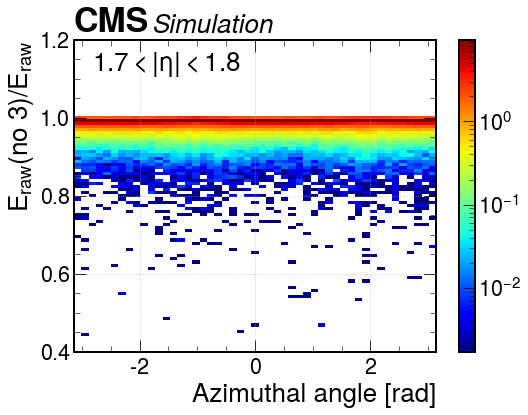

Quantiles for energy response 50%= 0.009211122989654541 90%= 0.02945847511291505  99%= 0.07612112760543815


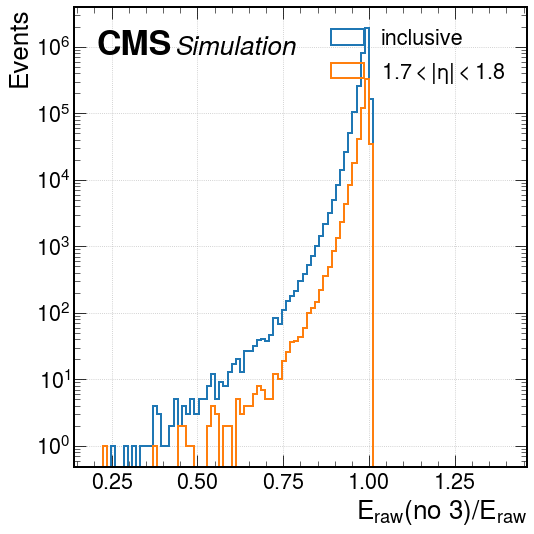

In [14]:
def compareEnergyLoss(df,eden,enum,ylabel,pfix=''):

    mask=(df['genAbsEta']>1.7) & (df['genAbsEta']<1.8)

    
    fig,ax=plt.subplots(figsize=(8,6))
    h=plt.hist2d(df['genAbsEta'],df[enum]/df[eden],
                 bins=(np.linspace(1.6,2.4,60),np.linspace(0.4,1.2,100)),
                 cmap='jet', density=True, norm=ColorsLogNorm())
    fig.colorbar(h[3])
    plt.grid()
    plt.xlabel(r'|$\eta$|')
    plt.ylabel(ylabel)
    fig.tight_layout()
    hep.cms.label(loc=0,data=False,ax=ax,rlabel='') 
    plt.savefig(f'{_plotdir}/elossvseta_{enum}_{eden}{pfix}.png')
    plt.show()
    
    fig,ax=plt.subplots(figsize=(8,6))
    h=plt.hist2d(df[mask].reset_index()['genEn'],df[mask][enum]/df[mask][eden],
                 bins=(np.linspace(10,500,50),np.linspace(0.4,1.2,100)),
                 cmap='jet', density=True, norm=ColorsLogNorm())
    fig.colorbar(h[3])
    plt.grid()
    plt.text(0.05,0.9,r'$1.7<|\eta|<1.8$',transform=ax.transAxes)
    plt.xlabel(r'Generated energy [GeV]')
    plt.ylabel(ylabel)
    fig.tight_layout()
    hep.cms.label(loc=0,data=False,ax=ax,rlabel='') 
    plt.savefig(f'{_plotdir}/elossvsen_{enum}_{eden}{pfix}.png')
    plt.show()
    
    fig,ax=plt.subplots(figsize=(8,6))
    h=plt.hist2d(df[mask].reset_index()['genPhi'],df[mask][enum]/df[mask][eden],
                 bins=(np.linspace(-np.pi,np.pi,50),np.linspace(0.4,1.2,100)),
                 cmap='jet', density=True, norm=ColorsLogNorm())
    fig.colorbar(h[3])
    plt.grid()
    plt.text(0.05,0.9,r'$1.7<|\eta|<1.8$',transform=ax.transAxes)
    plt.xlabel(r'Azimuthal angle [rad]')
    plt.ylabel(ylabel)
    fig.tight_layout()
    hep.cms.label(loc=0,data=False,ax=ax,rlabel='') 
    plt.savefig(f'{_plotdir}/elossvsphi_{enum}_{eden}{pfix}.png')
    plt.show()
    
    fig,ax=plt.subplots(figsize=(8,8))
    kwargs={'bins':np.linspace(0.2,1.4,100),'linewidth':2,'histtype':'step'}
    eloss=(df[enum]/df[eden]).values
    eloss=eloss[~np.isnan(eloss)]
    ax.hist(eloss,**kwargs,label='inclusive')
    
    eloss_gap=(df[enum]/df[eden]).values
    eloss_gap=eloss_gap[mask & ~np.isnan(eloss_gap)]
    ax.hist(eloss_gap,**kwargs,label=r'$1.7<|\eta|<1.8$')

    print('Quantiles for energy response 50%=',np.percentile(1-eloss,q=50), '90%=',np.percentile(1-eloss,q=90),' 99%=',np.percentile(1-eloss,q=99))
    ax.grid()
    ax.set_xlabel(ylabel)
    ax.set_yscale('log')
    ax.set_ylabel('Events')
    ax.legend()
    fig.tight_layout()
    hep.cms.label(loc=1,data=False,ax=ax,rlabel='') 
    plt.savefig(f'{_plotdir}/elosspdf_{enum}_{eden}{pfix}.png')
    plt.show()
    
compareEnergyLoss(df_merged[''],'en_l0','en_l0no3',r'$E_{raw}(no~3)/E_{raw}$')
#compareEnergyLoss(df_merged['late'],'en_l0','en_l0no3',r'$E_{raw}(no~3)/E_{raw}$','late')
#compareEnergyLoss(df_merged['antikt'],'en_l0','en_l0antikt',r'$\frac{E_{raw}(SimHits, anti-k_T)}{E_{raw}(SimHits, \Delta R)}$','antikt')
#compareEnergyLoss(df_merged['lc_antikt'],'en_l0','en_l0lc',r'$\frac{E_{raw}(LayerClusters, anti-k_T)}{E_{raw}(SimHits, anti-k_T)}$','rhvslc')
#compareEnergyLoss(df_merged['lc_antikt_ca'],'en_l0','en_l0ca',r'$\frac{E_{raw}(LayerClusters, C-A)}{E_{raw}(LayerClusters, anti-k_T)}$','lcantiktvsca')

In [ ]:
fig,ax=plt.subplots(figsize=(8,8))
kwargs={'bins':np.linspace(0.2,1.05,100),'linewidth':2,'histtype':'step'}

for tag,label in [('','inclusive'),('late','late-starting')]:
    eloss=(df_merged[tag]['en_l0no3']/df_merged[tag]['en_l0']).values
    eloss=eloss[~np.isnan(eloss)]
    ax.hist(eloss,label=label,**kwargs)
    print(tag,np.percentile(1-eloss,q=90),np.percentile(1-eloss,q=99))
ax.grid()
ax.set_xlabel(r'$E_{raw}(no threes)/E_{raw}$')
ax.set_yscale('log')
ax.set_ylabel('Events')
ax.legend(loc='upper left')
fig.tight_layout()
hep.cms.label(loc=0,data=False,ax=ax,rlabel='') 
plt.savefig(f'{_plotdir}/elosspdf{tag}.png')
plt.show()